# 6. Multivariate inference

## Markov Chain Monte Carlo methods

- MCMC methods can be used to estimate the posterior in an efficient way
- In MCMC, the goal is to generate chains that after some iterations start sampling from the posterior
- The posterior densities are then obtained in a Monte Carlo way: $\rho_{\delta}({ \mathbf{\theta}}) = m({\mathbf{\theta}_{\delta}})/n$
- A popular approach for MCMC is the Metropolis-Hastings algorithm: 

```{figure} ../figures/mcmc_algo.png
:alt: mcm algo
:width: 600px
:align: center
```

## Task
Solve **exercise 5**, but with 3 parameters: 

```{figure} ../figures/mutivariate_inference.png
:alt: mcm algo
:width: 300px
:align: center
```

Assume:
- Prior $E$ ~ $N(60,20)$ GPa
- Prior $Q$ ~ $N(60,30)$ kN
- Prior $x_Q$ ~ $U(0,10000)$ mm

Obtain: 
- Posterior distribution 
- Pair-plot
- Trace-plot
- Posterior predictive 

:::{hint}
:class: dropdown

```{figure} ../figures/mutivariate_hint.png
:alt: mcm algo
:width: 600px
:align: center
```
:::


:::{tip}
:class: dropdown
**Tips for working with emcee**

Tuning algorithm:
- Rule of thumb: $n_{walkers} = 10* n_{params}$
- Make sure that the likelihood is supported in the entire prior domain (not ‘nans’)

Convergence:
- We define a burn-in phase to discard samples still correlated to initial points
- Number of initial samples (burn-in phase)  Difficult to define a priori
- Always check with Trace plots
- Once converged, only a few steps (e.g. 100) are needed for most relevant metrics

Advanced topics:
- Read the emcee paper: [emcee: The MCMC Hammer](https://arxiv.org/abs/1202.3665)
- [Autocorrelation analysis & convergence — emcee](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)
- [Parallelization — emcee](https://emcee.readthedocs.io/en/stable/tutorials/parallel/)

:::

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal, Uniform
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel
from probeye.definition.correlation_model import ExpModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

## Problem setup

In [2]:
# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm

# Measurements
x_sensors = [2500, 5000]  # mm  (always from lower to higher, bug in inv_cov_vec_1D in tripy)
d_sensors = [35, 50]  # mm
sigma_model = 2.5  # mm
pearson = 0.5
l_corr = -np.abs(x_sensors[1] - x_sensors[0]) / np.log(pearson)  # mm (assuming exponential correlation)

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa
Q_mean = 60  # kN
Q_std = 30  # kN
Q_loc_low = 0  # mm
Q_loc_high = 10000  # mm

## Define forward model

In [3]:
def beam_deflection(E, Q, a, x):  # a is load position, x is sensor position
    if x < a:
        b = L - a
        return Q * b * x * (L ** 2 - b ** 2 - x ** 2) / (6 * E * I * L)
    
    return Q * a * (L - x) * (2 * L * x - x ** 2 - a ** 2) / (6 * E * I * L)

In [4]:
class BeamModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E", "Q", "a"]
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        E = inp["E"]
        Q = inp["Q"]
        a = inp["a"]
        x = inp["x"]
        return {"y": [beam_deflection(E, Q, a, float(x[0])), beam_deflection(E, Q, a, float(x[1]))]}  # float() needed, probably a bug in probeye

## Define inverse problem

In [5]:
# Instantiate the inverse problem
problem = InverseProblem("Beam model with two sensors", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)
problem.add_parameter(
    "Q",
    tex="$Q$",
    info="Load applied to the beam (kN)",
    prior=Normal(mean=Q_mean, std=Q_std),
)
problem.add_parameter(
    "a",
    tex="$a$",
    info="Position of the load (mm)",
    prior=Uniform(low=Q_loc_low, high=Q_loc_high)
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the model error (mm)",
    value=sigma_model,
)
problem.add_parameter(
    "l_corr",
    tex="$l_{corr}$",
    info="Correlation length of the model error (mm)",
    value=l_corr,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_sensors, "y": d_sensors}
)
                 
# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
likelihood_model = GaussianLikelihoodModel(
        experiment_name="TestSeries_1", 
        model_error="additive",
        correlation=ExpModel(x="l_corr")
        )
problem.add_likelihood_model(likelihood_model)


## Solve with MCMC

In [6]:
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)

2024-07-09 12:28:07.181 | INFO     | Solving problem using emcee sampler with 2000 + 2000 samples and 20 walkers                          | probeye.inference.emcee.solver:run:178
2024-07-09 12:28:07.182 | INFO     | No additional options specified                                                                      | probeye.inference.emcee.solver:run:186


100%|██████████| 2000/2000 [00:16<00:00, 120.49it/s]

2024-07-09 12:28:40.394 | INFO     | Sampling of the posterior distribution completed: 2000 steps and 20 walkers.                         | probeye.inference.emcee.solver:run:255
2024-07-09 12:28:40.395 | INFO     | Total run-time (including initial sampling): 33s.                                                    | probeye.inference.emcee.solver:run:259
2024-07-09 12:28:40.395 | INFO     |                                                                                                      | probeye.inference.emcee.solver:run:260
2024-07-09 12:28:40.396 | INFO     | Summary of sampling results (emcee)                                                                  | probeye.inference.emcee.solver:run:261
2024-07-09 12:28:40.401 | INFO     |        mean    median       sd       5%      95%                                                     | probeye.inference.emcee.solver:emcee_summary:137
2024-07-09 12:28:40.401 | INFO     | --  -------  --------  -------  -------  -------          

## Posterior plot

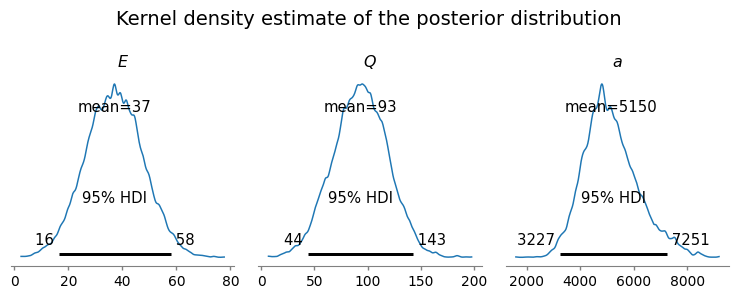

In [7]:
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)

## Pair plot

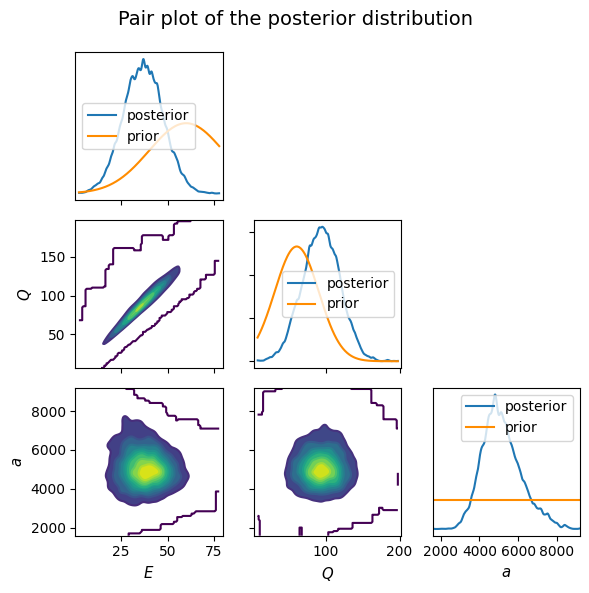

In [8]:
pair_plot_array = create_pair_plot(
    inference_data,
    emcee_solver.problem,
    focus_on_posterior=True,
    show_legends=True,
    title="Pair plot of the posterior distribution",
)

## Trace plot

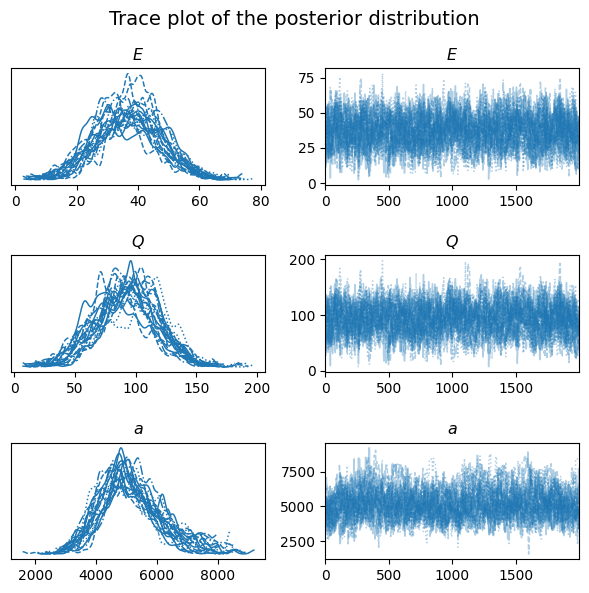

In [9]:
trace_plot_array = create_trace_plot(
    inference_data,
    emcee_solver.problem,
    title="Trace plot of the posterior distribution",
)

## Posterior predictives

In [10]:
# Extract samples
posterior_samples = inference_data.posterior.to_array()  # parameters, chains, samples
posterior_samples = np.array(posterior_samples)
posterior_samples = posterior_samples.reshape(posterior_samples.shape[0], -1).T  # samples, parameters

# Make predictions for x in the range of the beam
x_range = np.linspace(0, 10000, 100)
predictions = np.zeros((len(posterior_samples), len(x_range)))

for i, sample in enumerate(posterior_samples):
    E = sample[0]
    Q = sample[1]
    a = sample[2]
    predictions[i, :] = [beam_deflection(E, Q, a, x) for x in x_range]

# Calculate mean and 95% intervals
mean_pred = np.mean(predictions, axis=0)
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)

## Plot posterior predictive

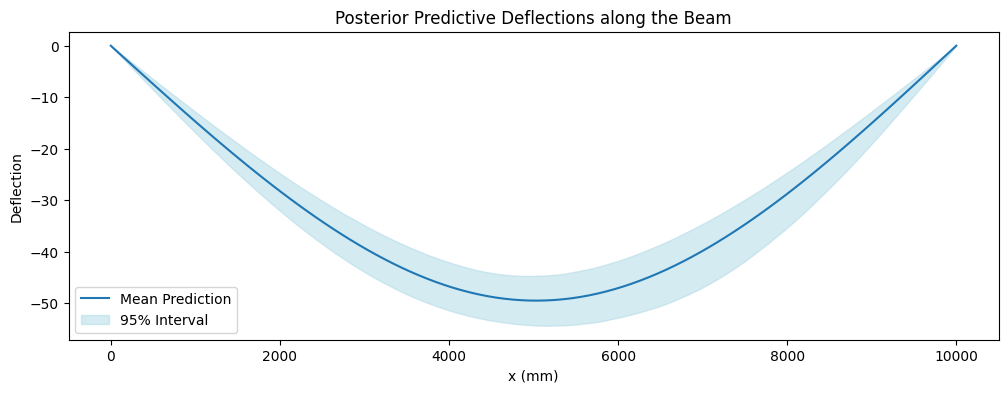

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(x_range, -mean_pred, label='Mean Prediction')
plt.fill_between(x_range, -lower_bound, -upper_bound, color='lightblue', alpha=0.5, label='95% Interval')
plt.xlabel('x (mm)')
plt.ylabel('Deflection')
plt.title('Posterior Predictive Deflections along the Beam')
plt.legend()
plt.show()

:::{note} Complete Code! 📃💻
:class: dropdown
Here’s the complete code that you would run in your PC:

```python

import matplotlib.pyplot as plt
import numpy as np

# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal, Uniform
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel
from probeye.definition.correlation_model import ExpModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm

# Measurements
x_sensors = [2500, 5000]  # mm  (always from lower to higher, bug in inv_cov_vec_1D in tripy)
d_sensors = [35, 50]  # mm
sigma_model = 2.5  # mm
pearson = 0.5
l_corr = -np.abs(x_sensors[1] - x_sensors[0]) / np.log(pearson)  # mm (assuming exponential correlation)

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa
Q_mean = 60  # kN
Q_std = 30  # kN
Q_loc_low = 0  # mm
Q_loc_high = 10000  # mm


def beam_deflection(E, Q, a, x):  # a is load position, x is sensor position
    if x < a:
        b = L - a
        return Q * b * x * (L ** 2 - b ** 2 - x ** 2) / (6 * E * I * L)
    
    return Q * a * (L - x) * (2 * L * x - x ** 2 - a ** 2) / (6 * E * I * L)
	
	
class BeamModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E", "Q", "a"]
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        E = inp["E"]
        Q = inp["Q"]
        a = inp["a"]
        x = inp["x"]
        return {"y": [beam_deflection(E, Q, a, float(x[0])), beam_deflection(E, Q, a, float(x[1]))]}  # float() needed, probably a bug in probeye
		
		
# Instantiate the inverse problem
problem = InverseProblem("Beam model with two sensors", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)
problem.add_parameter(
    "Q",
    tex="$Q$",
    info="Load applied to the beam (kN)",
    prior=Normal(mean=Q_mean, std=Q_std),
)
problem.add_parameter(
    "a",
    tex="$a$",
    info="Position of the load (mm)",
    prior=Uniform(low=Q_loc_low, high=Q_loc_high)
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the model error (mm)",
    value=sigma_model,
)
problem.add_parameter(
    "l_corr",
    tex="$l_{corr}$",
    info="Correlation length of the model error (mm)",
    value=l_corr,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_sensors, "y": d_sensors}
)
                 
# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
likelihood_model = GaussianLikelihoodModel(
        experiment_name="TestSeries_1", 
        model_error="additive",
        correlation=ExpModel(x="l_corr")
        )
problem.add_likelihood_model(likelihood_model)

#solve mcmc
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)


#posterior plot
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)

#pair plot
pair_plot_array = create_pair_plot(
    inference_data,
    emcee_solver.problem,
    focus_on_posterior=True,
    show_legends=True,
    title="Pair plot of the posterior distribution",
)

#trace plot
trace_plot_array = create_trace_plot(
    inference_data,
    emcee_solver.problem,
    title="Trace plot of the posterior distribution",
)

#Posterior predictives
# Extract samples
posterior_samples = inference_data.posterior.to_array()  # parameters, chains, samples
posterior_samples = np.array(posterior_samples)
posterior_samples = posterior_samples.reshape(posterior_samples.shape[0], -1).T  # samples, parameters

# Make predictions for x in the range of the beam
x_range = np.linspace(0, 10000, 100)
predictions = np.zeros((len(posterior_samples), len(x_range)))

for i, sample in enumerate(posterior_samples):
    E = sample[0]
    Q = sample[1]
    a = sample[2]
    predictions[i, :] = [beam_deflection(E, Q, a, x) for x in x_range]

# Calculate mean and 95% intervals
mean_pred = np.mean(predictions, axis=0)
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)


#Plot posterior predictive

plt.figure(figsize=(12, 4))
plt.plot(x_range, -mean_pred, label='Mean Prediction')
plt.fill_between(x_range, -lower_bound, -upper_bound, color='lightblue', alpha=0.5, label='95% Interval')
plt.xlabel('x (mm)')
plt.ylabel('Deflection')
plt.title('Posterior Predictive Deflections along the Beam')
plt.legend()
plt.show()
```
:::